# Stage 2 - Medical Indicators 
An analytical model to assist physicians in classifying patients with high and low chance of having a heart attack.

<br>

**Goal:**
- obtain important features (medical) for predicting heart attack risk
- the best model that automatically predict heart attack risk based on the important features (>80% accuracy rate) 

**Dataset:**
- heart_attack_cleaned_text.csv

**Models:**
1. CART
2. Random Forest

**PipeLine:**
1. `Train-test split`
2. Train on dataset (CART, Random Forest)
3. Final model `evaluation` with test dataset

<br>

<hr>



## 1. Pre-modelling preparations

- Import libraries and dataset
- Train-test split
- Metrics to measure performance

#### 1.1 Import libraries and dataset

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyp  lot
sb.set() # set the default Seaborn style for graphics

# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix



from sklearn.tree import plot_tree

In [2]:
# note: dataset is already OneHotEncoded and Integer Encoded in 'data-cleaning-preprocessing.ipynb'
ha_df = pd.read_csv('datasets/heart_attack_cleaned.csv')
ha_df

,age,sex,chest_pain,resting_blood_pressure,chol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_induced_angina,num_of_major_vessels,heart_attack_chance,o2_saturation
0,63,1,3,145,233,1,0,150,0,0,1,98.6
1,37,1,2,130,250,0,1,187,0,0,1,98.6
2,41,0,1,130,204,0,0,172,0,0,1,98.6
3,56,1,1,120,236,0,1,178,0,0,1,98.1
4,57,0,0,120,354,0,1,163,1,0,1,97.5
...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,0,140,241,0,1,123,1,0,0,97.5
298,45,1,3,110,264,0,1,132,0,0,0,97.5
299,68,1,0,144,193,1,1,141,0,2,0,97.5
300,57,1,0,130,131,0,1,115,1,1,0,97.5


#### 1.2 Train-Test Split

In [3]:
X = ha_df.drop(['heart_attack_chance'], axis=1)
y = ha_df.iloc[:,-2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [4]:
X_train.head()

,age,sex,chest_pain,resting_blood_pressure,chol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_induced_angina,num_of_major_vessels,o2_saturation
137,62,1,1,128,208,1,0,140,0,0,97.5
106,69,1,3,160,234,1,0,131,0,1,97.5
284,46,1,0,140,311,0,1,120,1,2,96.5
44,39,1,2,140,321,0,0,182,0,0,97.5
139,64,1,0,128,263,0,1,105,1,1,97.5


#### 1.3 Metrics to Measure Performance
- Classification Accuracy (5-fold cross validation with roc-auc-score)
- Confusion Matrix
- Precision, Recall, and F-score
- Out-of-bag (oob) score (for random forest)
- ROC AUC Curve score

<br>

**Why ROC AUC Score instead of overall accuracy for the 5-fold cross validation score (we will term it as classification accuracy for eaiser understanding for business stakeholders)?**
- We care equally about true positive and true negative classes
- AUC calibrates the trade-off between sensitivity and specificity at the best-chosen threshold
- While overall accuracy measures how well a single model is doing, AUC compares two models as well as evaluates the same model's performance across different thresholds

<br>

**Reference:**
- https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
- https://www.kdnuggets.com/2022/10/metric-accuracy-auc.html
- https://github.com/ztjhz/SC1015-Project/blob/main/Anime/classification.ipynb (done by Jing Qiang from SC1015 module 🐱‍👤)

In [5]:
# Confusion Matrix
def confusion_matrix_TPR_TNR(y, y_pred, scores, train_test_string):
    from sklearn.metrics import confusion_matrix
    
    # Confusion Matrix
    c_matrix = confusion_matrix(y, y_pred)

    # True Negatives & True Positives
    TN = c_matrix[0][0]
    FP = c_matrix[1][0]
    FN = c_matrix[0][1]
    TP = c_matrix[1][1]

    # True Positive Rate, True Negative Rate, False Positive Rate, False Negative Rate
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    FPR = FP/(TN+FP)
    FNR = FN/(TP+FN)

    # Check the Goodness of Fit (on Train Data)
    print(f"Goodness of Fit of Model ({train_test_string} Dataset)")
    print("Classification Accuracy:", scores.mean())
    print("True Positive Rate:", TPR)
    print("True Negative Rate:", TNR)
    print("False Postive Rate:", FPR)
    print("False Negative Rate:", FNR)

    # Plot the Confusion Matrix
    plt.figure(figsize=(8, 8))
    sb.heatmap(c_matrix, 
               annot = True, 
               fmt=".0f", 
               annot_kws={"size": 18}).set(title=f"Confusion Matrix ({train_test_string} Dataset)")
    print()

In [6]:
# Precision and Recall
def get_precision_recall(y, y_pred):
    from sklearn.metrics import precision_score, recall_score
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    
    print("Precision:", precision)
    print("Recall:", recall)
    
    return [precision, recall]

# F-score
def get_f1_score(y, y_pred):
    from sklearn.metrics import f1_score
    
    f1 = f1_score(y, y_pred)
    
    print("f1_score:", f1)
    
    return f1

In [7]:
# Out-of-bag (oob) score
def get_oob_score(random_forest):
    print("oob score:", round(random_forest.oob_score_ * 100, 2), "%")

In [8]:
# ROC AUC Curve score
def ROC_AUC(random_forest, X_train, y_train, train_test):
    try:
        # getting the probabilities of our predictions
        y_scores = random_forest.predict_proba(X_train)
        y_scores = y_scores[:,1]

        from sklearn.metrics import roc_curve
        # compute true positive rate and false positive rate
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)

        # plotting them against each other
        def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
            plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
            plt.plot([0, 1], [0, 1], 'r', linewidth=4)
            plt.axis([0, 1, 0, 1])
            plt.xlabel('False Positive Rate (FPR)', fontsize=16)
            plt.ylabel('True Positive Rate (TPR)', fontsize=16)
            plt.title(f'{train_test} Dataset')

        plt.figure(figsize=(14, 7))
        plot_roc_curve(false_positive_rate, true_positive_rate)
        plt.show()


        # ROC AUC Score
        from sklearn.metrics import roc_auc_score
        r_a_score = roc_auc_score(y_train, y_scores)
        print("ROC-AUC-Score:", r_a_score)
    except:
        pass

**Function that evaluates a classifier model's performance based on various metrics**
- Cross Validation prediction (CV=5)

In [39]:
def model_performance(classifier_model, X_train, X_test, y_train, y_test):
    # Import libraries
    from sklearn.model_selection import cross_val_predict
    from sklearn.model_selection import cross_val_score
    
    # K-Fold Cross Validation
    y_train_pred = cross_val_predict(classifier_model, X_train, y_train, cv=5)
    y_test_pred = cross_val_predict(classifier_model, X_test, y_test, cv=5)
    
    train_scores = cross_val_score(classifier_model, X_train, y_train, cv=5, scoring = "roc_auc")
    test_scores = cross_val_score(classifier_model, X_test, y_test, cv=5, scoring = "roc_auc")
    
    # Performance metrics

    print("-> Train Dataset")
    confusion_matrix_TPR_TNR(y_train, y_train_pred, train_scores, "Train")
    get_precision_recall(y_train, y_train_pred)
    get_f1_score(y_train, y_train_pred)

    print("\n\n-----\n-> Test Dataset")
    confusion_matrix_TPR_TNR(y_test, y_test_pred, test_scores, "Test")
    get_precision_recall(y_test, y_test_pred)
    get_f1_score(y_test, y_test_pred)
    ROC_AUC(classifier_model, X_test, y_test, "Test")
    print('-----\n')
    
    try:
        get_oob_score(classifier_model)
    except:
        pass
    

<hr>

## 2. CART - Classification Tree

**Why CART?**

**References:**
- https://towardsdatascience.com/cart-classification-and-regression-trees-for-clean-but-powerful-models-cc89e60b7a85
- https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

#### 2.1 Model Building - Growing tree to the maximum

In [13]:
# Decision Tree using Train Data
dectree_m1 = DecisionTreeClassifier(random_state=0)  # create the decision tree object
dectree_m1.fit(X_train, y_train)       # train the decision tree model

# Predict Legendary values corresponding to Total
y_train_pred = dectree_m1.predict(X_train)
y_test_pred = dectree_m1.predict(X_test)


#### 2.2 Evaluating Model Performance

In [14]:
def printTree(dectree):
    f = plt.figure(figsize=(12,12))
    plot_tree(dectree ,filled=True, feature_names=ha_df.columns, rounded=True, class_names=["Y","N"])

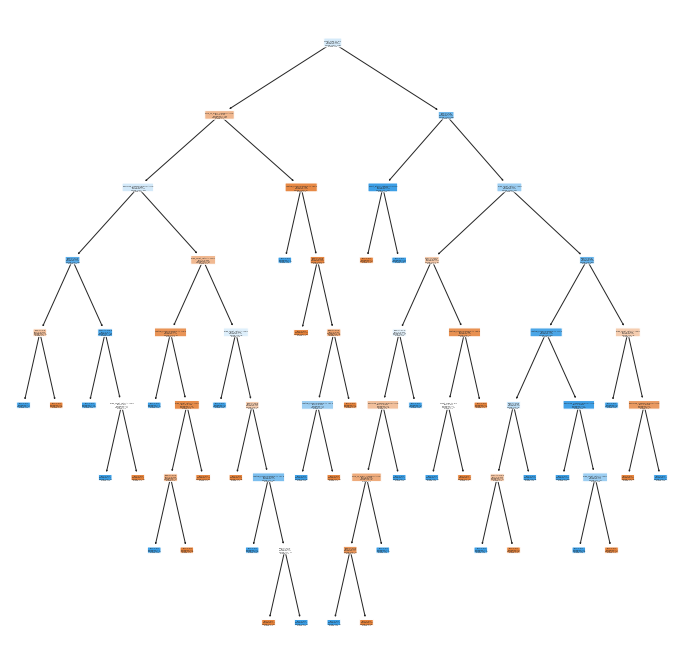

In [15]:
printTree(dectree_m1)

-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.7689486397152302
True Positive Rate: 0.7966101694915254
True Negative Rate: 0.7419354838709677
False Postive Rate: 0.25806451612903225
False Negative Rate: 0.2033898305084746

Precision: 0.7966101694915254
Recall: 0.7966101694915254
f1_score: 0.7966101694915254


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.6725
True Positive Rate: 0.673469387755102
True Negative Rate: 0.6666666666666666
False Postive Rate: 0.3333333333333333
False Negative Rate: 0.32653061224489793

Precision: 0.673469387755102
Recall: 0.7021276595744681
f1_score: 0.6875000000000001


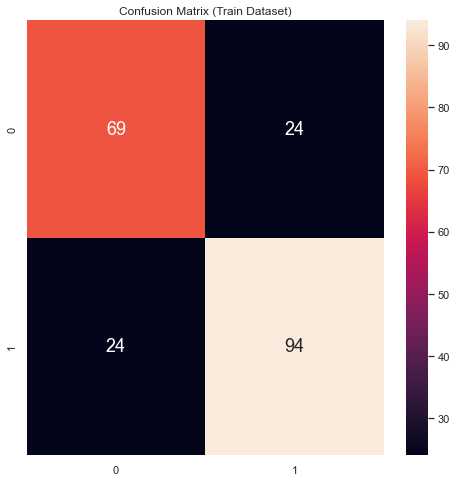

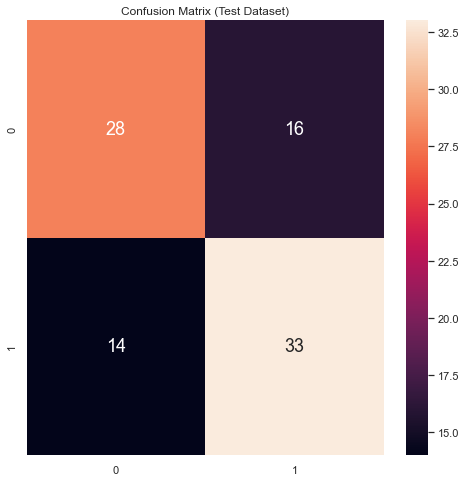

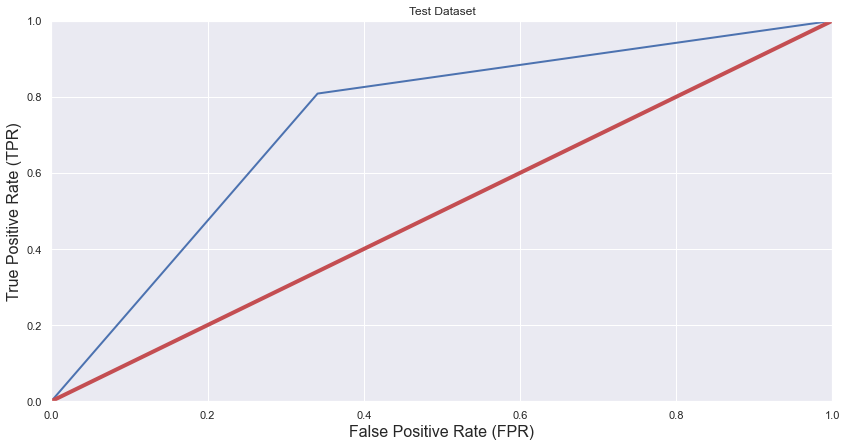

ROC-AUC-Score: 0.7338007736943908
-----



In [40]:
model_performance(dectree_m1, X_train, X_test, y_train, y_test)

#### 2.3 Model Optimisation - Tree-Pruning

- a) Find `alpha`
- b) Prune tree with chosen `cp` value

**2.3 a) Find alpha**

In [17]:
path = dectree_m1.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.0035545  0.00421274 0.00440081 0.0044899  0.00458645
 0.00563115 0.00607131 0.00631912 0.00631912 0.00762807 0.00789889
 0.00858156 0.00925947 0.00926804 0.00937096 0.00987362 0.01021664
 0.01043611 0.01820336 0.02663551 0.03491118 0.06028983 0.12109236]


In [18]:
# For each alpha, we will append our model to a list
dectreeList = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    dectreeList.append(clf)

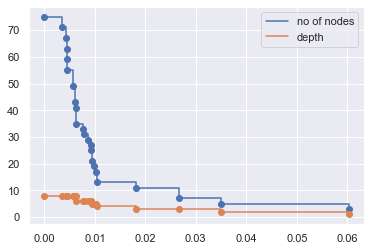

In [19]:
import matplotlib.pyplot as plt

dectreeList = dectreeList[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [dtr.tree_.node_count for dtr in dectreeList]
depth = [dtr.tree_.max_depth for dtr in dectreeList]

plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()
#As alpha increases no of nodes and depth decreases

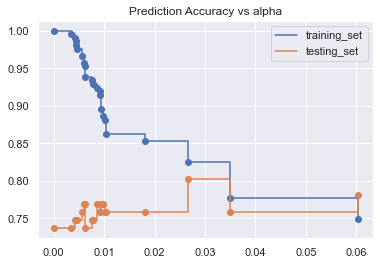

In [20]:
train_acc = []
test_acc = []
for c in dectreeList:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='training_set',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='testing_set',drawstyle="steps-post")
plt.legend()
plt.title('Prediction Accuracy vs alpha')
plt.show()


- The accuracy of training set and testing set is a trade-off
- We want to maximize both as much as possible -> the point between alpha 0.02 - 0.03 is spotted 
- Hence cp value 0.03 is chosen.

**2.3 b) Prune Tree with Chosen CP value**

In [21]:
dectree_m2 = DecisionTreeClassifier(random_state=0,ccp_alpha=0.03)
dectree_m2.fit(X_train,y_train)
y_train_pred = dectree_m2.predict(X_train)
y_test_pred = dectree_m2.predict(X_test)

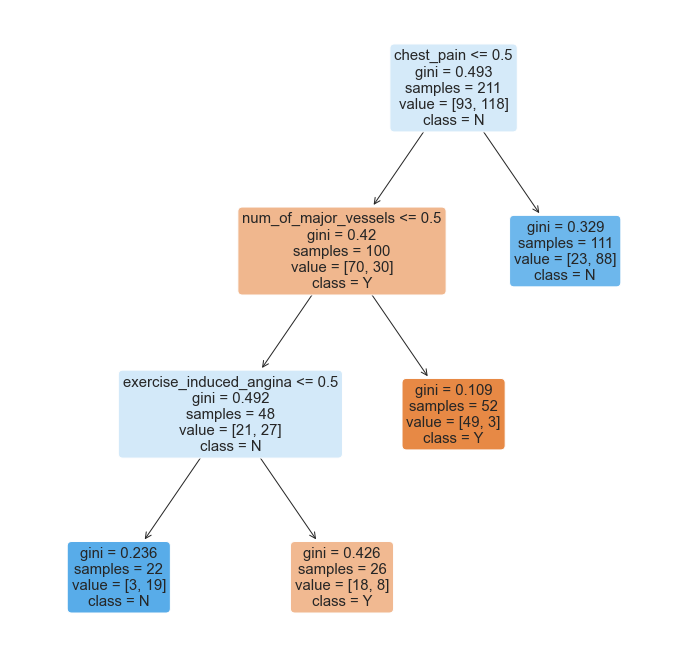

In [22]:
printTree(dectree_m2)

-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.7968916857360793
True Positive Rate: 0.7703703703703704
True Negative Rate: 0.8157894736842105
False Postive Rate: 0.18421052631578946
False Negative Rate: 0.22962962962962963

Precision: 0.7703703703703704
Recall: 0.8813559322033898
f1_score: 0.8221343873517786


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.7440586419753086
True Positive Rate: 0.6956521739130435
True Negative Rate: 0.6666666666666666
False Postive Rate: 0.3333333333333333
False Negative Rate: 0.30434782608695654

Precision: 0.6956521739130435
Recall: 0.6808510638297872
f1_score: 0.6881720430107526


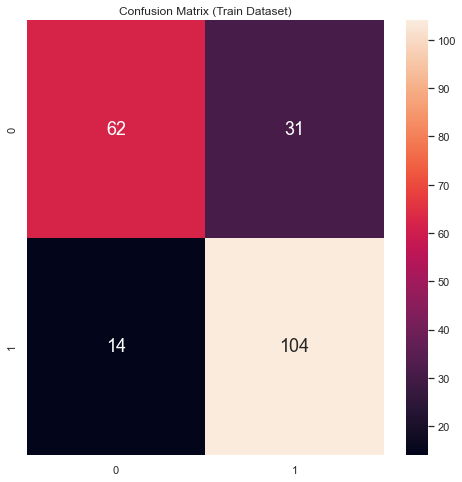

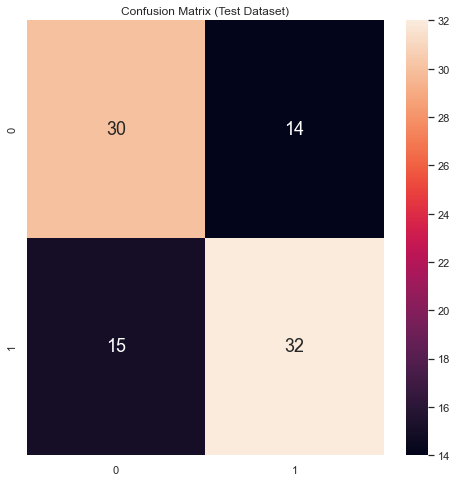

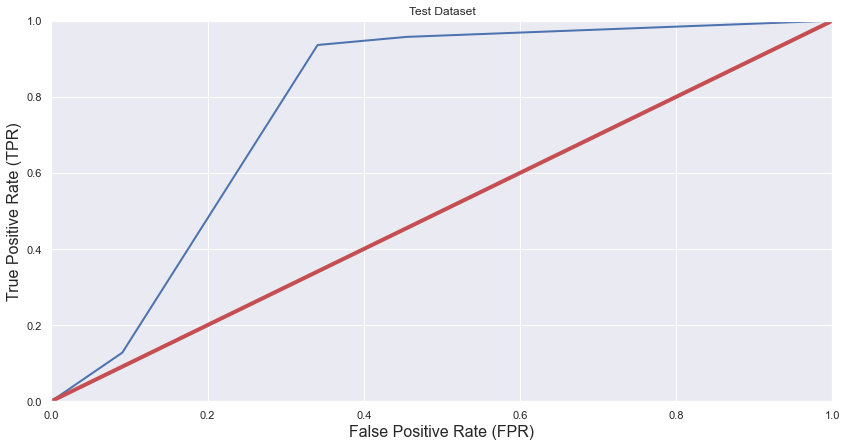

ROC-AUC-Score: 0.7802224371373307
-----



In [41]:
model_performance(dectree_m2, X_train, X_test, y_train, y_test)

**Conclusion**:
- After pruning, the CART model is performing `better` now!
- Classification accuracy for both train and test dataset have `increased` (from 67% to 74% for test dataset)
- True Positive Rate `increased` and False Negative Rate have `decreased`
- The ROC AUC Score also `increased` significantly to 0.78

#### 2.4 CART Conclusion

- Decent classification accuracy on test dataset (`74%`) after optimsing the model with tree-pruning.
- Decent true positive rate, false negative rate, f1-score, and ROC AUC score on test set

<br>

**However, since stage 2 is used by doctors, we want to have a model that have a better classication accuracy (>80%).**
**Therefore, we will use Random Forest Classifier to improve the prediction accuracy as random forest is an ensemble of CART!**

---

## 3. Random Forest

**Why Random Forest?**
- Random forest is essentially a CART algorithm (Classification and Regression Trees), except it creates an `ensemble of many trees` instead of just one.
  - Improved performance (the wisdom of crowds)
  - Improved robustness (less likely to overfit since it relies on many random trees)

<br>

**Difference compared to CART**
- Random forest algorithm randomly selects observations and features to build several decision trees and then averages the results.
- "deep" decision trees might suffer from overfitting. Most of the time, random forest prevents this by creating random subsets of the features and building smaller trees using those subsets. Afterwards, it combines the subtrees. It's important to note this doesn’t work every time and it also makes the computation slower, depending on how many trees the random forest builds.

<br>

**References:**
- https://towardsdatascience.com/random-forest-models-why-are-they-better-than-single-decision-trees-70494c29ccd1
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier
- https://github.com/ztjhz/SC1015-Project/blob/main/Anime/classification.ipynb (done by Jing Qiang from SC1015 module 🐱‍👤)

#### 3.1 Model Building (random_forest_m1)

In [24]:
# Random Forest
random_forest_m1 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
random_forest_m1.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=42)

-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.8894816297991357
True Positive Rate: 0.859504132231405
True Negative Rate: 0.8444444444444444
False Postive Rate: 0.15555555555555556
False Negative Rate: 0.14049586776859505

Precision: 0.859504132231405
Recall: 0.8813559322033898
f1_score: 0.8702928870292886


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.8431327160493828
True Positive Rate: 0.7954545454545454
True Negative Rate: 0.7446808510638298
False Postive Rate: 0.2553191489361702
False Negative Rate: 0.20454545454545456

Precision: 0.7954545454545454
Recall: 0.7446808510638298
f1_score: 0.7692307692307692


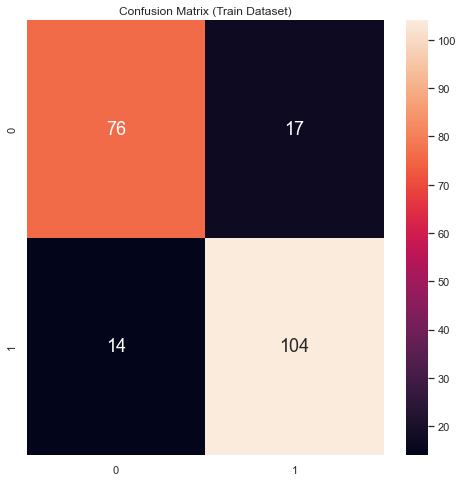

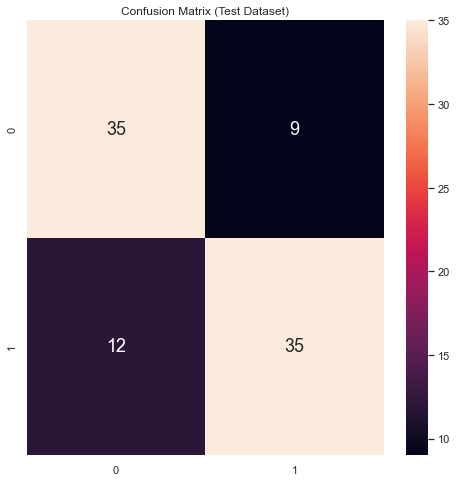

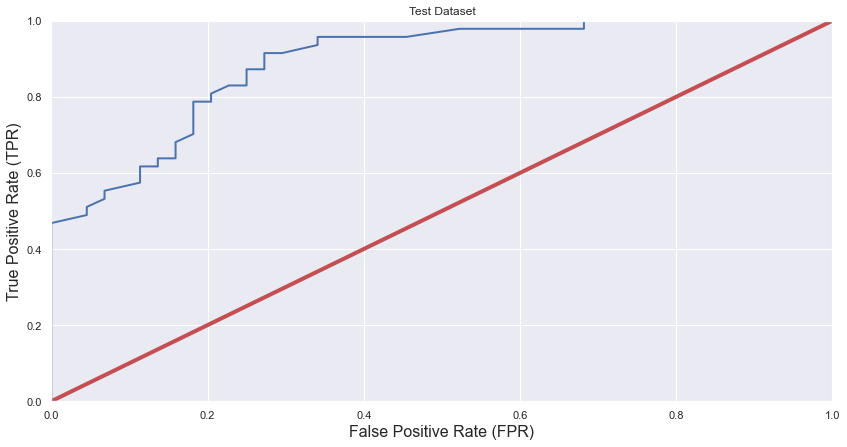

ROC-AUC-Score: 0.8902321083172147
-----

oob score: 83.89 %


In [42]:
model_performance(random_forest_m1, X_train, X_test, y_train, y_test)

**Conclusion (random_forest_m1 vs dectree_m2)**
- All performance metrics on train and test dataset `increased significantly!`
  - Classification accuracy increased significantly from around 74% on test dataset to around `84%`
  - f-score, and ROC AUC score increased significantly
  - True positive rate increased, and false negative rate decreased significantly from 0.3 to 0.2

<br>

**Reason for change:**
- Random forest buildis multiple decision trees and merges them together to get a more accurate and stable prediction
- Random Forest adds additonal randomness to the model, while growing the trees
- Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features.
- Random forest algorithm randomly selects observations and features to build several decision trees and then averages the results.
- "deep" decision trees might suffer from overfitting. Most of the time, random forest prevents this by creating random subsets of the features and building smaller trees using those subsets. Afterwards, it combines the subtrees. It's important to note this doesn’t work every time and it also makes the computation slower, depending on how many trees the random forest builds.

<br>

**Lets improve the random forest's performance even more by looking at feature importance**

#### 3.2 Optimising Model with `feature importance` (random_forest_m2)

**3.2 a) Feature Importance**

- Sklearn measure features importance by looking at how much the tree nodes, that use that feature and reduce impurity on average (across all trees in the forest).
- The score is scaled such that the sum of all important feature is equal to 1.

In [26]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest_m1.feature_importances_, 3)})
importances = importances.sort_values('importance',ascending=False).reset_index(drop=True)

In [27]:
importances

,feature,importance
0,max_heart_rate,0.158
1,num_of_major_vessels,0.157
2,chest_pain,0.136
3,age,0.108
4,exercise_induced_angina,0.105
5,chol,0.104
6,resting_blood_pressure,0.091
7,sex,0.064
8,o2_saturation,0.040
9,rest_ecg,0.024


<AxesSubplot:xlabel='feature'>

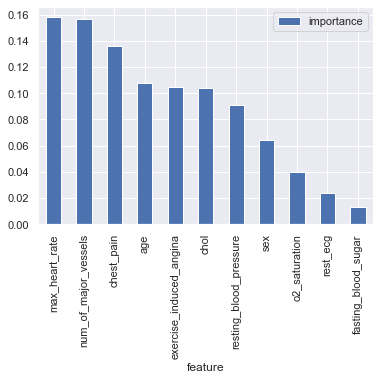

In [28]:
importances.plot.bar(x='feature', y='importance')

**Note:**
- The bottom feature with the lowest importance score is very low (0.013) compared to the other features
- Let's try to optimise the model by dropping that feature

<br>

**3.2 b) Optimising random forest classifier with key important features**
- drop feature `fasting_blood_sugar`

In [29]:
#note: other numbers of features dropped has been tested. Only dropping 'fasting_blood_sugar' will increase the model performance
cols_to_drop = ['fasting_blood_sugar']

# Random Forest
random_forest_m2 = RandomForestClassifier(n_estimators=100, oob_score = True, random_state=42)
random_forest_m2.fit(X_train.drop(cols_to_drop, axis=1), y_train)


RandomForestClassifier(oob_score=True, random_state=42)

-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.8955425247902365
True Positive Rate: 0.8617886178861789
True Negative Rate: 0.8636363636363636
False Postive Rate: 0.13636363636363635
False Negative Rate: 0.13821138211382114

Precision: 0.8617886178861789
Recall: 0.8983050847457628
f1_score: 0.8796680497925312


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.8171296296296298
True Positive Rate: 0.8
True Negative Rate: 0.7608695652173914
False Postive Rate: 0.2391304347826087
False Negative Rate: 0.2

Precision: 0.8
Recall: 0.7659574468085106
f1_score: 0.7826086956521738


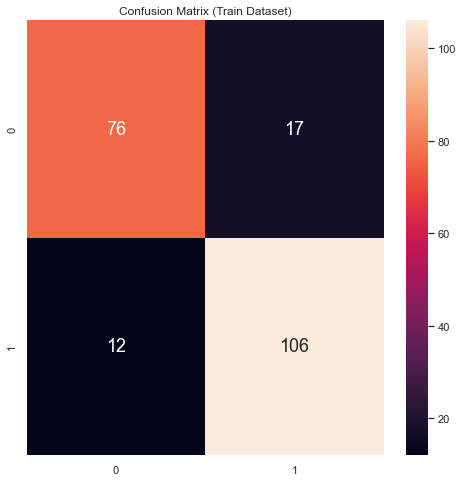

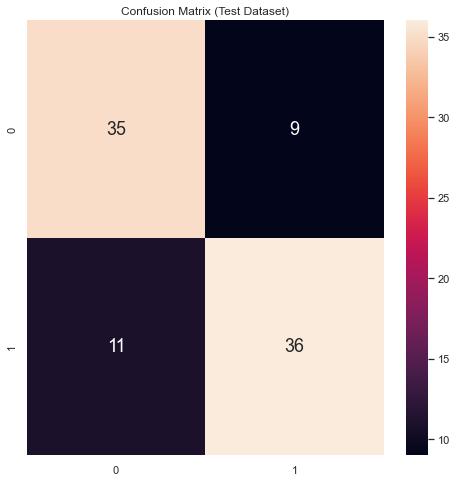

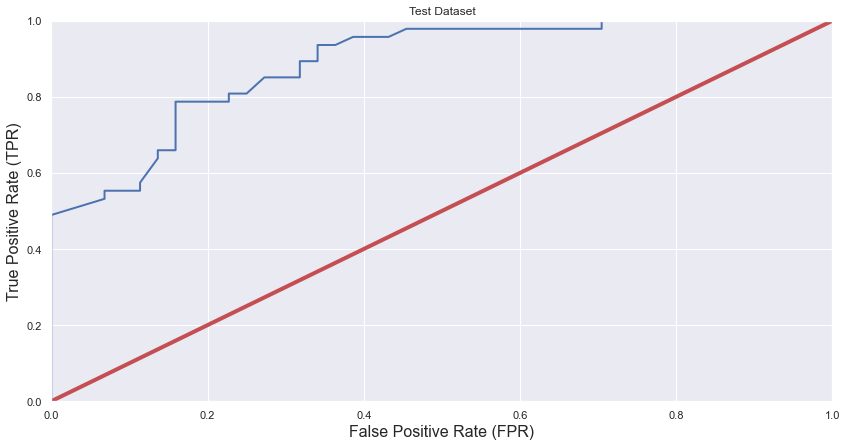

ROC-AUC-Score: 0.8870889748549323
-----

oob score: 84.83 %


In [43]:
model_performance(random_forest_m2, X_train.drop(cols_to_drop, axis=1), X_test.drop(cols_to_drop, axis=1), y_train, y_test)

**Conclusion (random_forest_m2 vs random_forest_m1):**

- All performance metrics on train and test dataset `are relatively the same`
  - Classification accuracy decreased from around 84% on test dataset to around `81%`

<br>

Thus, `random_forest_m1` is a better model! It seems like all the features are somewhat important in the prediction. If not important, they would have a value of 0 for their importance value. 

Let's improve the model (random_forest_m1) by using hyperparameter tuning.

#### 3.3 Optimising Model with `Hyperparameter Tuning` (random_forest_m3)

- The hyperparameters in random forest are either used to increase the predictive power of the model or to make the model faster.
- Using `GridSearchCV` to find the best hyperparameters: `criterion`, `min_samples_leaf`, `min_samples_split`, `n_estimators`

<br>

> `n_estimators` hyperparameter
>
> - Which is just the number of trees the algorithm builds before taking the maximum voting or taking the averages of predictions.
> - In general, a higher number of trees increases the performance and makes the predictions more stable, but it also slows down the computation.

<br>

**Reference:**
- https://github.com/ztjhz/SC1015-Project/blob/main/Anime/classification.ipynb (done by Jing Qiang from SC1015 module 🐱‍👤)



**3.3 a) Hyperparameter Tuning**

**Code written in markdown since it takes a long time to run the tuning process:**

```
# GridSerachCV
param_grid = {
    "criterion" : ["gini", "entropy"],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 70],
    "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35],
    "n_estimators": [100, 400, 700, 1000, 1500]
}

from sklearn.model_selection import GridSearchCV, cross_val_score

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42, n_jobs=-1)

clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

clf.fit(X_train, y_train)

clf.best_params_
```

Hyperparameter Tuning Output:

```
{
    'criterion': 'entropy',
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 100
}
```    

<br>

- By undergoing hyperparameter tuning, we can control the behavior of the model. If we don’t correctly tune our hyperparameters, our model parameters will produce suboptimal results as they don’t minimize the loss function, thus the model makes more errors
- Hence, hyperparameter tuning maximises the model performance

In [31]:
# Output of the hyperparameter tuning
best_params_ = {
    'criterion': 'entropy',
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 100
}

best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

**3.3 b) Test optimised parameters**

In [32]:
# Random Forest
random_forest_m3 = RandomForestClassifier(
    criterion="entropy",
    min_samples_leaf=1,
    min_samples_split=4, 
    n_estimators=100, 
    oob_score=True,
    random_state=42
)

random_forest_m3.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', min_samples_split=4, oob_score=True,
                       random_state=42)

-> Train Dataset
Goodness of Fit of Model (Train Dataset)
Classification Accuracy: 0.8944719891516231
True Positive Rate: 0.8666666666666667
True Negative Rate: 0.8461538461538461
False Postive Rate: 0.15384615384615385
False Negative Rate: 0.13333333333333333

Precision: 0.8666666666666667
Recall: 0.8813559322033898
f1_score: 0.8739495798319329


-----
-> Test Dataset
Goodness of Fit of Model (Test Dataset)
Classification Accuracy: 0.8505864197530864
True Positive Rate: 0.7906976744186046
True Negative Rate: 0.7291666666666666
False Postive Rate: 0.2708333333333333
False Negative Rate: 0.20930232558139536

Precision: 0.7906976744186046
Recall: 0.723404255319149
f1_score: 0.7555555555555555


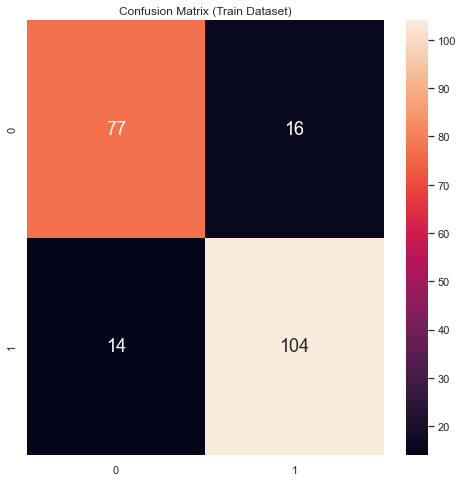

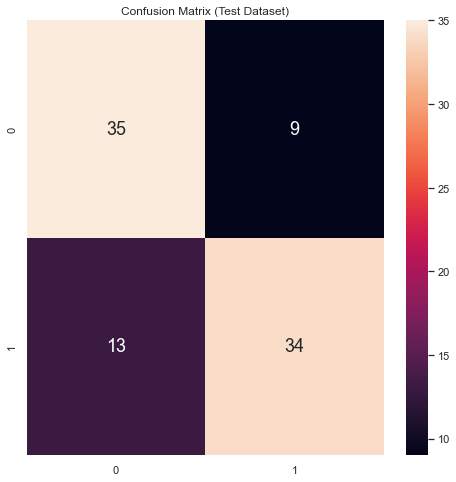

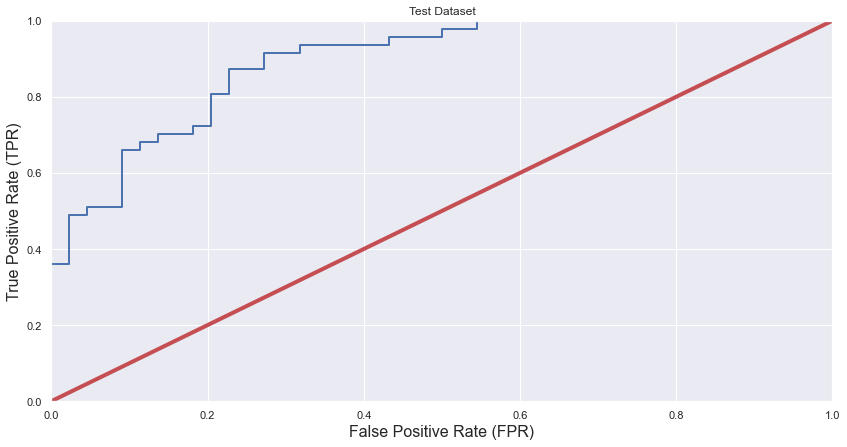

ROC-AUC-Score: 0.8916827852998066
-----

oob score: 84.36 %


In [44]:
model_performance(random_forest_m3, X_train, X_test, y_train, y_test)

**Conclusion (random_forest_m1 vs random_forest_m3):**
- Most performance metrics `slightly increased` because optimised hyperparameter is used in random_forest_m3.
- Classification accuracy on test dataset increased from 84% to `85%`.


#### 3.4 Optimal Model (random_forest_m3) Conclusion

**Important features:**
1. max_heart_rate
2. num_of_major_vessels
3. chest_pain
4. age
5. exercise_induced_angina
6. chol
7. resting_blood_pressure
8. sex
9. o2_saturation
10. rest_ecg
11. resting_blood_sugar

**Best Hyperparameter:**

```
{
    'criterion': 'entropy',
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 100
}
```

**Performance on test dataset:**
- Around 85% accuracy
- Good ROC AUC score (~0.89)

In [34]:
# important features (without fasting_blood_sugar)
importances

,feature,importance
0,max_heart_rate,0.158
1,num_of_major_vessels,0.157
2,chest_pain,0.136
3,age,0.108
4,exercise_induced_angina,0.105
5,chol,0.104
6,resting_blood_pressure,0.091
7,sex,0.064
8,o2_saturation,0.040
9,rest_ecg,0.024


#### 3.5 Export Random Forest Classifier (random_forest_m3)

**3.5 a) Export**

In [35]:
# Save Model Using joblib
import joblib

# save the models to disk
filename = 'models/stage2_random_forest_m3.sav'
joblib.dump(random_forest_m3, filename)

['models/stage2_random_forest_m3.sav']

**3.5 b) How to Import:**

In [36]:
# some time later...

# load the model from disk
loaded_random_forest_m3 = joblib.load('models/stage2_random_forest_m3.sav')
result = cross_val_score(loaded_random_forest_m3, X_test, y_test, cv=5, scoring = "roc_auc").mean()
print(result)

0.8505864197530864


---

## 4. Stage 2 Conclusion

- `Random Forest Classifier` (random_forest_m3) perform better than CART (85% vs 74%)

<br>

**The 10 important features are:**
1. max_heart_rate
2. num_of_major_vessels
3. chest_pain
4. age
5. exercise_induced_angina
6. chol
7. resting_blood_pressure
8. sex
9. o2_saturation
10. rest_ecg
11. fasting_blood_sugar

<br>

Therefore, doctors can gather the above medical information regarding patients to gain insight into their patients' cadiovascular health.

In [37]:
pd.DataFrame([cross_val_score(random_forest_m3, X_test, y_test, cv=5, scoring = "roc_auc").mean(), cross_val_score(dectree_m2, X_test, y_test, cv=5, scoring = "roc_auc").mean()], columns=["Analytic Model"], index=["Random Forest","CART"])

,Analytic Model
Random Forest,0.850586
CART,0.744059


In [38]:
# Sample

# asumming this this a individual's answers (after OneHotEncoding)
medicalResult = pd.DataFrame(X_train.loc[2,]).T

result = "DANGER! Give patient a full body checkup!" if random_forest_m3.predict(medicalResult)[0] else "Patient is quite safe. Give simple medical tests :)"

print(result)

DANGER! Give patient a full body checkup!
